In [11]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore
from mcmodels.core import Mask

from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
connectivity_data = get_connectivity_data(cache, major_structure_ids[:12], experiments_exclude, remove_injection = False)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()


512
703
1089
1097
315
313
354
698
771
803
477
549


In [6]:
connectivity_data.get_data_matrices(default_structure_ids)

In [7]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)

#contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
#ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order_leaves)[np.isin(ontological_order_leaves, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [8]:
connectivity_data.get_crelines(data_info)

In [ ]:
connectivity_data.sum

In [9]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [51]:
summary_structures = {}
for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
    
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)

In [52]:
connectivity_data.str2_index_matrices = get_indices_2ormore(connectivity_data.summary_structures)

In [64]:

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)

def get_loss_surface_cv(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances_cv, fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

# def get_cre_distances_cv(proj, means_cast, sids,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(leafs[sid] == leafs[sid][i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

#     return(credist)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #meani = meani = means_cast[sids[i]][cres[i]]
        meani = means_cast[sids[i]][cres[i]]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)


def get_connectivity_matrices(connectivity_data, cres, structure_dict, source_ordering, target_ordering, structure_major_dictionary,gamma_dict = None):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(cres)
    
    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions     
                                                      
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        #print(iy)
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)   
    
    #reorder = np.concatenate([ipsi_indices, contra_indices])  
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction(cache, connectivity_data.structure_datas[sid], structures = structure_dict[sid], prediction_region=source_ordering[i], cre = cres[c], gamma = gamma, surface = connectivity_data.structure_datas[sid].loss_surface_cv, cre_model = True)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)


def get_region_prediction(cache, structure_data,  structures, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    leaf_experiments = np.where(structures == prediction_region)[0]
    nexp = len(leaf_experiments)
    centroids = structure_data.centroids[leaf_experiments]
    cres = structure_data.crelines[leaf_experiments]
    projections = structure_data.reg_proj_norm[leaf_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

    if surface != None and cre_model != True:
        means = get_means(projections,cres, np.repeat(prediction_region,nexp))
        
        losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
        predictions = get_nw_predictions(projections, losses, gamma)
        output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        means = get_means(projections, cres, np.repeat(prediction_region,nexp))
        #print(means)
        if np.isin(cre, np.asarray(list(means[prediction_region].keys()))):
            losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
            predictions = get_nw_predictions(projections, losses, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
            
    if surface == None and cre_model != True:
        means = get_means(projections, cres, [prediction_region])
        predictions = means[cres]
        output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
        output = np.mean(predictions, axis = 0)
        
    
    return(output)


def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)


def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

    
def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)


In [20]:
#wrong dist (not remove)... try to recreate old result
frac_learn = np.ones(12)
frac_learn[4] = .1
sls = {}
gammas_surface = 100000 * np.ones(12)
gammas_surface[0] = 10
gammas_surface[1] = 10
gammas_surface[2] = 1000
gammas_surface[3] = 100
gammas_surface[4] = 20000
gammas_surface[3] = 100
gammas_surface[5] = 100
gammas_surface[6] = 10
gammas_surface[7] = 100
gammas_surface[8] = 100
gammas_surface[9] = 25
gammas_surface[10] = 1000
gammas_surface[11] = 1000

for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                 connectivity_data.creline[sid],
                                                                                 connectivity_data.leafs[sid],
                                                                                 
                                                                                 #connectivity_data.structure_datas[sid].summary_structures,
                                                                                 #connectivity_data.s[sid],
                                                                                 frac_learn[m],
                                                                                 gamma = gammas_surface[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


<IPython.core.display.Javascript object>


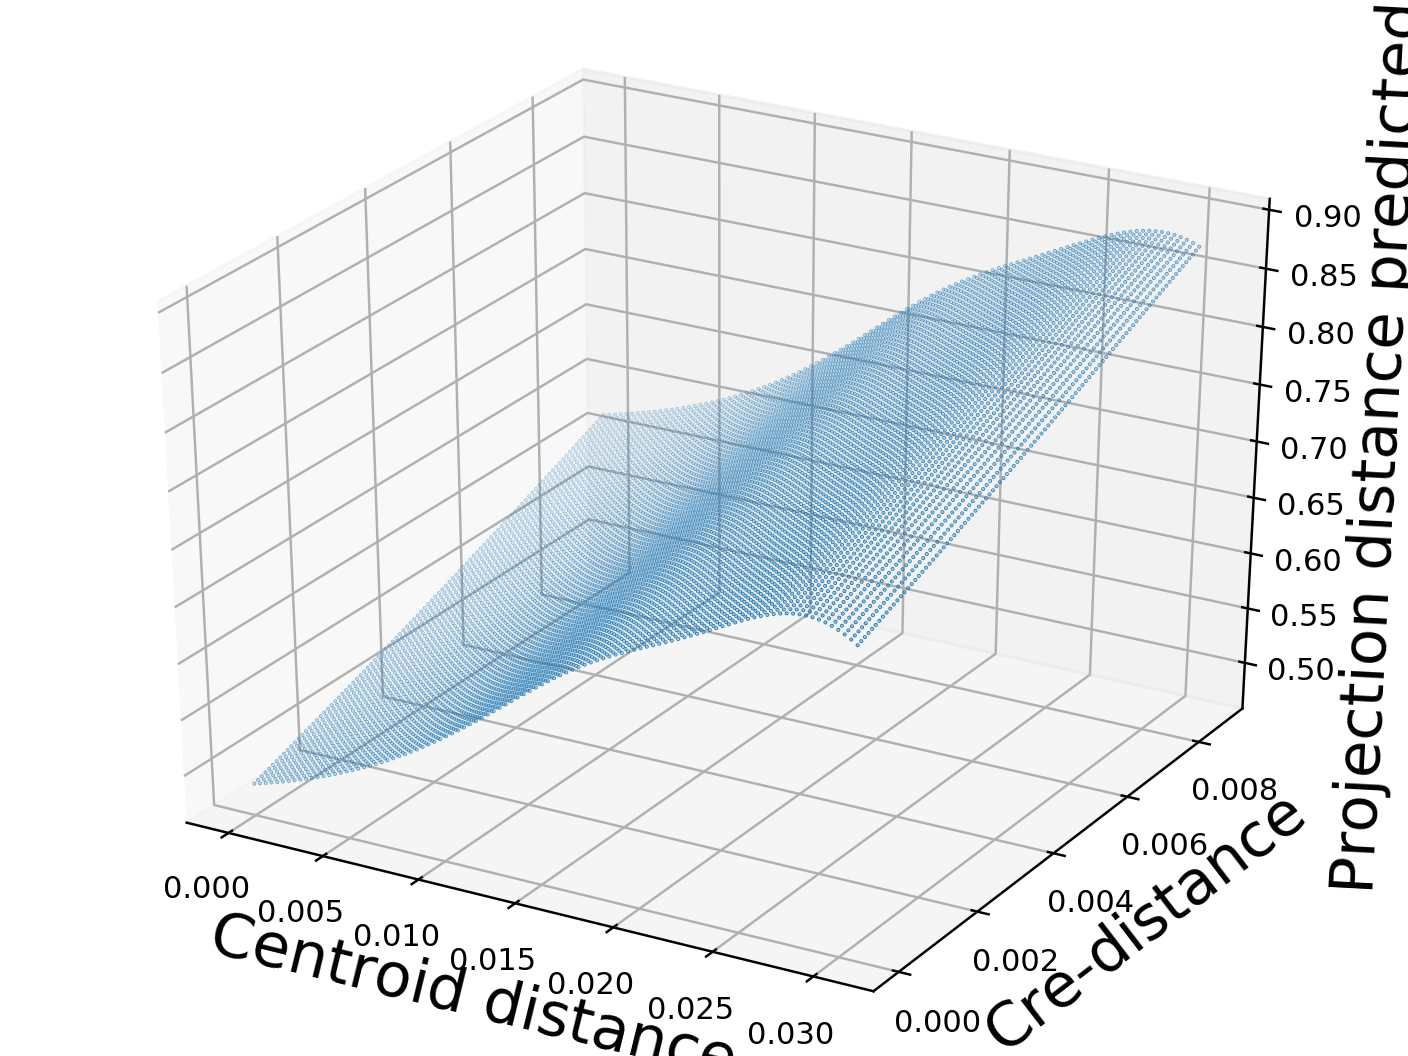

In [14]:
%matplotlib notebook
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv)
#plt.savefig('/Users/samsonkoelle/isocortexsurface')

In [21]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].smoothed_losses = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv)

In [22]:
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)


In [23]:
connectivity_data.structure_datas[sid].smoothed_losses.shape

(83, 83)

In [24]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
m 0 3 0.0020073974 nan
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
m 1 2 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.0020073974 nan
e [ 9 19] m [ 9 19]
e [ 9 19] m [ 9 19]
e [ 9 19] m [ 9 19]
e [ 9 19] m [ 9 19]
e [ 9 19] m [ 9 19]
e [ 9 19] m [ 9 19]
e [ 9 19] m [ 9 19]
m 5 2 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0020073974 nan
e [ 5  7 14 15 30 31] m [ 5  7 14 15 30 31]
e [ 5  7 14 15 30 31] m [ 5  7 14 15 30 31]
e [ 5  7 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
m 0 0 0.0030163364 nan
e [ 50  88 113] m [ 50  88 113]
e [ 50  88 113] m [ 50  88 113]
e [ 50  88 113] m [ 50  88 113]
e [ 50  88 113] m [ 50  88 113]
e [ 50  88 113] m [ 50  88 113]
e [ 50  88 113] m [ 50  88 113]
e [ 50  88 113] m [ 50  88 113]
m 1 3 0.0030163364 nan
e [  3  13  44  45  49  61  68 120] m [  3  13  44  45  49  61  68 120]
e [  3  13  44  45  49  61  68 120] m [  3  13  44  45  49  61  68 120]
e [  3  13  44  45  49  61  68 120] m [  3  13  44  45  49  61  68 120]
e [  3  13  44  45  49  61  68 120] m [  3  13  44  45  49  61  68 120]
e [  3  13  44  45  49  61  68 120] m [  3  13  44  45  49  61  68 120]
e [  3  13  44  45  49  61  68 120] m [  3  13  44  45  49  61  68 120]
e [  3  13  44  45  49  61  68 120] m [  3  13  44  45  49  61  68 120]
m 2 8 0.0030163364 0.004384050263862306
e [  0  32  37  38  51  52  66  70  86  91 103 108] m [  0  32  37  38  51  52  66  70  86  91 103 108]
e [  0  32  37  38  51  52  66  70  86  91 103 108] 

m 4 4 0.005063931 nan
e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
m 5 8 0.005063931 0.005267374972510476
e [13 36 46] m [13 36 46]
e [13 36 46] m [13 36 46]
e [13 36 46] m [13 36 46]
e [13 36 46] m [13 36 46]
e [13 36 46] m [13 36 46]
e [13 36 46] m [13 36 46]
e [13 36 46] m [13 36 46]
m 6 3 0.005063931 0.008902953667303806
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 2

e [ 114  495  865 1014 1025] m [ 114  495  865 1014 1025]
e [ 114  495  865 1014 1025] m [ 114  495  865 1014 1025]
e [ 114  495  865 1014 1025] m [ 114  495  865 1014 1025]
e [ 114  495  865 1014 1025] m [ 114  495  865 1014 1025]
e [ 114  495  865 1014 1025] m [ 114  495  865 1014 1025]
e [ 114  495  865 1014 1025] m [ 114  495  865 1014 1025]
m 9 5 0.004280918 0.005234870463972137
e [ 334  530  989 1092] m [ 334  530  989 1092]
e [ 334  530  989 1092] m [ 334  530  989 1092]
e [ 334  530  989 1092] m [ 334  530  989 1092]
e [ 334  530  989 1092] m [ 334  530  989 1092]
e [ 334  530  989 1092] m [ 334  530  989 1092]
e [ 334  530  989 1092] m [ 334  530  989 1092]
e [ 334  530  989 1092] m [ 334  530  989 1092]
m 10 4 0.004280918 0.003917717190613623
e [ 165  177  285  310  426  716 1020] m [ 165  177  285  310  426  716 1020]
e [ 165  177  285  310  426  716 1020] m [ 165  177  285  310  426  716 1020]
e [ 165  177  285  310  426  716 1020] m [ 165  177  285  310  426  716 1020]
e [

m 33 14 0.004280918 0.00544186526685763
e [ 309  323  596  963 1021 1050 1052] m [ 309  323  596  963 1021 1050 1052]
e [ 309  323  596  963 1021 1050 1052] m [ 309  323  596  963 1021 1050 1052]
e [ 309  323  596  963 1021 1050 1052] m [ 309  323  596  963 1021 1050 1052]
e [ 309  323  596  963 1021 1050 1052] m [ 309  323  596  963 1021 1050 1052]
e [ 309  323  596  963 1021 1050 1052] m [ 309  323  596  963 1021 1050 1052]
e [ 309  323  596  963 1021 1050 1052] m [ 309  323  596  963 1021 1050 1052]
e [ 309  323  596  963 1021 1050 1052] m [ 309  323  596  963 1021 1050 1052]
m 34 7 0.004280918 0.0034632704525565184
e [  60  947 1105] m [  60  947 1105]
e [  60  947 1105] m [  60  947 1105]
e [  60  947 1105] m [  60  947 1105]
e [  60  947 1105] m [  60  947 1105]
e [  60  947 1105] m [  60  947 1105]
e [  60  947 1105] m [  60  947 1105]
e [  60  947 1105] m [  60  947 1105]
m 35 3 0.004280918 nan
e [107 242 282 344 420 436 504 685 790] m [107 242 282 344 420 436 504 685 790]
e [1

m 48 3 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 49 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 50 0 0.004280918 nan
e [274 581 706] m [274 581 706]
e [274 581 706] m [274 581 706]
e [274 581 706] m [274 581 706]
e [274 581 706] m [274 581 706]
e [274 581 706] m [274 581 706]
e [274 581 706] m [274 581 706]
e [274 581 706] m [274 581 706]
m 51 3 0.004280918 nan
e [  95  105  136  211  244  299  361  401  480  484  547  611  642  655
  659  718  814  817  825  861  973 1010 1084] m [  95  105  136  211  244  299  361  401  480  484  547  611  642  655
  659  718  814  817  825  861  973 1010 1084]
e [  95  105  136  211  244  299  361  401  480  484  547  611  642  655
  659  718  814  817  825  861  973 1010 1084] m [  95  105  136  211  244  299  361  401  480  484  547  611  642  655
  659  718  814  817  825  861  973 1010 1084]
e [  95  105  136  211  244  299  361  401  480  484  547  611  

m 54 75 0.004280918 0.0039041086508544405
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 55 0 0.004280918 nan
e [   2   10   15   25   30   34   43   61   64   67  104  129  133  138
  143  161  163  170  193  198  225  232  241  258  259  267  287  327
  337  366  379  383  389  424  433  438  442  443  445  448  494  501
  505  526  531  536  571  574  590  594  608  609  612  620  627  636
  646  651  663  665  670  695  701  704  724  730  743  792  794  840
  841  880  881  885  886  900  908  927  928  939  942  950  951  954
  967  970  998 1007 1011 1023 1038 1069 1081 1087 1091 1107 1116 1123
 1124 1127] m [   2   10   15   25   30   34   43   61   64   67  104  129  133  138
  143  161  163  170  193  198  225  232  241  258  259  267  287  327
  337  366  379  383  389  424  433  438  442  443  445  448  494  501
  505  526  531  536  571  574  590  594  608  609  612  620  627  636
  646  651  663  665  670  695  701  704  724  730  743  792  794  8

e [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  470  491  559  653  656  661  681  751  770  777  789  896  906
  912  949  988 1005 1019] m [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  470  491  559  653  656  661  681  751  770  777  789  896  906
  912  949  988 1005 1019]
e [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  470  491  559  653  656  661  681  751  770  777  789  896  906
  912  949  988 1005 1019] m [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  470  491  559  653  656  661  681  751  770  777  789  896  906
  912  949  988 1005 1019]
e [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  470  491  559  653  656  661  681  751  770  777  789  896  906
  912  949  988 1005 1019] m [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  470  491  559  653  656  661  681  751  770  777  789  896  906
 

e [  21   51   74   75   87   93   97  101  108  117  121  125  145  164
  178  197  199  201  207  208  210  214  216  221  222  227  231  246
  249  250  262  268  269  270  291  300  306  311  315  317  326  328
  335  336  346  347  348  349  351  358  374  394  397  407  444  459
  476  493  506  511  513  550  578  582  584  593  602  607  641  669
  696  703  709  717  722  727  740  748  762  765  771  778  780  798
  802  804  806  818  819  829  830  835  836  849  887  897  901  910
  918  919  924  929  931  932  934  945  962  971  980  983  984  999
 1040 1043 1060 1063 1067 1071 1080 1090 1096 1097 1102 1106] m [  21   51   74   75   87   93   97  101  108  117  121  125  145  164
  178  197  199  201  207  208  210  214  216  221  222  227  231  246
  249  250  262  268  269  270  291  300  306  311  315  317  326  328
  335  336  346  347  348  349  351  358  374  394  397  407  444  459
  476  493  506  511  513  550  578  582  584  593  602  607  641  669
  696  703 

m 71 10 0.004280918 0.0036107546106974716
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
m 72 6 0.004280918 0.0035022857347378916
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
m 73 8 0.004280918 0.

m 83 41 0.004280918 0.004119253683748242
e [  17   55  130  191  481  543  615  686  851  870  907 1059] m [  17   55  130  191  481  543  615  686  851  870  907 1059]
e [  17   55  130  191  481  543  615  686  851  870  907 1059] m [  17   55  130  191  481  543  615  686  851  870  907 1059]
e [  17   55  130  191  481  543  615  686  851  870  907 1059] m [  17   55  130  191  481  543  615  686  851  870  907 1059]
e [  17   55  130  191  481  543  615  686  851  870  907 1059] m [  17   55  130  191  481  543  615  686  851  870  907 1059]
e [  17   55  130  191  481  543  615  686  851  870  907 1059] m [  17   55  130  191  481  543  615  686  851  870  907 1059]
e [  17   55  130  191  481  543  615  686  851  870  907 1059] m [  17   55  130  191  481  543  615  686  851  870  907 1059]
e [  17   55  130  191  481  543  615  686  851  870  907 1059] m [  17   55  130  191  481  543  615  686  851  870  907 1059]
m 84 12 0.004280918 0.0036546373794983937
e [] m []
e [] m []
e

m 94 11 0.004280918 0.003979142232370898
e [ 192  261  295  507  551  823  866  888 1036] m [ 192  261  295  507  551  823  866  888 1036]
e [ 192  261  295  507  551  823  866  888 1036] m [ 192  261  295  507  551  823  866  888 1036]
e [ 192  261  295  507  551  823  866  888 1036] m [ 192  261  295  507  551  823  866  888 1036]
e [ 192  261  295  507  551  823  866  888 1036] m [ 192  261  295  507  551  823  866  888 1036]
e [ 192  261  295  507  551  823  866  888 1036] m [ 192  261  295  507  551  823  866  888 1036]
e [ 192  261  295  507  551  823  866  888 1036] m [ 192  261  295  507  551  823  866  888 1036]
e [ 192  261  295  507  551  823  866  888 1036] m [ 192  261  295  507  551  823  866  888 1036]
m 95 9 0.004280918 0.00391843165355659
e [ 217  553  750 1051 1101 1103] m [ 217  553  750 1051 1101 1103]
e [ 217  553  750 1051 1101 1103] m [ 217  553  750 1051 1101 1103]
e [ 217  553  750 1051 1101 1103] m [ 217  553  750 1051 1101 1103]
e [ 217  553  750 1051 1101 11

m 116 9 0.004280918 0.003823739565027455
e [399 965] m [399 965]
e [399 965] m [399 965]
e [399 965] m [399 965]
e [399 965] m [399 965]
e [399 965] m [399 965]
e [399 965] m [399 965]
e [399 965] m [399 965]
m 117 2 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 118 0 0.004280918 nan
(119, 7, 1128, 1077)
e [ 2 58 61] m [ 2 58 61]
e [ 2 58 61] m [ 2 58 61]
e [ 2 58 61] m [ 2 58 61]
e [ 2 58 61] m [ 2 58 61]
e [ 2 58 61] m [ 2 58 61]
e [ 2 58 61] m [ 2 58 61]
e [ 2 58 61] m [ 2 58 61]
m 0 3 0.0044946857 0.0034176578477212774
e [14 49 64] m [14 49 64]
e [14 49 64] m [14 49 64]
e [14 49 64] m [14 49 64]
e [14 49 64] m [14 49 64]
e [14 49 64] m [14 49 64]
e [14 49 64] m [14 49 64]
e [14 49 64] m [14 49 64]
m 1 3 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0044946857 nan
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m

e [11 21 23] m [11 21 23]
e [11 21 23] m [11 21 23]
m 5 3 0.0049728127 0.004028222132764859
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0049728127 nan
e [ 0 29] m [ 0 29]
e [ 0 29] m [ 0 29]
e [ 0 29] m [ 0 29]
e [ 0 29] m [ 0 29]
e [ 0 29] m [ 0 29]
e [ 0 29] m [ 0 29]
e [ 0 29] m [ 0 29]
m 7 2 0.0049728127 nan
e [ 3 22] m [ 3 22]
e [ 3 22] m [ 3 22]
e [ 3 22] m [ 3 22]
e [ 3 22] m [ 3 22]
e [ 3 22] m [ 3 22]
e [ 3 22] m [ 3 22]
e [ 3 22] m [ 3 22]
m 8 2 0.0049728127 nan
e [ 9 27] m [ 9 27]
e [ 9 27] m [ 9 27]
e [ 9 27] m [ 9 27]
e [ 9 27] m [ 9 27]
e [ 9 27] m [ 9 27]
e [ 9 27] m [ 9 27]
e [ 9 27] m [ 9 27]
m 9 2 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 10 0 0.0049728127 nan
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
m 11 2 0.0049728127 0.003059716363098103
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e

e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.003704043 nan
e [34 55] m [34 55]
e [34 55] m [34 55]
e [34 55] m [34 55]
e [34 55] m [34 55]
e [34 55] m [34 55]
e [34 55] m [34 55]
e [34 55] m [34 55]
m 23 2 0.003704043 nan
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
m 24 3 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.003704043 nan
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
m 26 6 0.003704043 0.0029571522883963123
e [27 59 71] m [27 59 71]
e [27 59 71] m [27 59 71]
e [27 59 71] m [27 59 71]
e [27 59 71] m [27 59 71]
e [27 59 71] 

In [19]:
#summary smoothing, 2stage
meanloss_nw_leaf_leaf2_2stage

array([0.03991072, 0.60140432, 0.08818358, 0.20692969, 0.19050812,
       0.14578681, 0.15729665, 0.0529763 , 0.2574036 , 0.14085968,
       0.04951165, 0.29990461])

In [25]:
#leaf smoothing, 2stage
meanloss_nw_leaf_leaf2_2stage
#why worse?  maybe default?

array([0.03991072, 0.60140432, 0.08764683, 0.20692969, 0.16012786,
       0.144303  , 0.15729665, 0.0529763 , 0.2574036 , 0.14085968,
       0.04951165, 0.29644311])

In [26]:
connectivity_data.structure_datas[sid].reg_proj_vcount_norm.shape

(83, 1077)

In [31]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    #pds = pairwise_distances(connectivity_data.structure_datas[sid].reg_proj_norm)
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.creleaf2_index_matrices[sid], 
                                                                                       connectivity_data.creleaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0020073974 nan
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
m 4 2 0.0020073974 0.0012813909801480132
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 33 0 0.0020073974 nan
(34, 7, 36, 1077)
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0046113897 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0046113897 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0046113897 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0046113897 nan
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
m 4 2 0.0046113897 0.007226992534697425
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0046113897 nan
(6, 7, 7, 1077)


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
m 0 2 0.0030163364 0.0033898193160578
e [ 39  74 116] m [ 39  74 116]
e [ 39  74 116] m [ 39  74 116]
e [ 39  74 116] m [ 39  74 116]
e [ 39  74 116] m [ 39  74 116]
e [ 39  74 116] m [ 39  74 116]
e [ 39  74 116] m [ 39  74 116]
e [ 39  74 116] m [ 39  74 116]
m 1 3 0.0030163364 0.0022659042462778497
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0030163364 nan
e [24 30] m [24 30]
e [24 30] m [24 30]
e [24 30] m [24 30]
e [24 30] m [24 30]
e [24 30] m [24 30]
e [24 30] m [24 30]
e [24 30] m [24 30]
m 3 2 0.0030163364 0.0020526719547719237
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 15 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 16 0 0.0030163364 nan
e [52 91] m [52 91]
e [52 91] m [52 91]
e [52 91] m [52 91]
e [52 91] m [52 91]
e [52 91] m [52 91]
e [52 91] m [52 91]
e [52 91] m [52 91]
m 17 2 0.0030163364 0.004153033596483631
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 18 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 19 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 20 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0030163364 nan
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


m 31 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 32 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 33 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 34 0 0.0030163364 nan
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
e [ 67 118] m [ 67 118]
m 35 2 0.0030163364 0.004616407110500293
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 36 0 0.0030163364 nan
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
m 22 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.005063931 nan
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
m 26 3 0.005063931 0.003140315990734985
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
m 27 3 0.005063931 0.003910551998857237
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.005063931 nan
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
m 29 2 0.00

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 2 0 0.004280918 nan
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
e [437 471] m [437 471]
m 3 2 0.004280918 0.004795193932176713
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.004280918 nan
e [423 619] m [423 619]
e [423 619] m [423 619]
e [423 619] m [423 619]
e [423 619] m [423 619]
e [423 619] m [423 619]
e [423 619] m [423 619]
e [423 619] m [423 619]
m 7 2 0.004280918 0.0040932852760198705
e [140 233 283 302 562] m [140 233 283 302 562]
e [140 233 283 302 562] m [140 233 283 302 562]
e [140 233 283 302 562] m [140 233 283 302 562]
e [140 233 283 302 562] m [140 233 283 302 562]
e [140 233 283 302 562] m [140 233 283 302 562]
e [140 233 283 302 562] m [140 233 283 302 562]

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


m 14 2 0.004280918 0.004640939093635217
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
m 15 3 0.004280918 0.004445556863936485
e [859 936] m [859 936]
e [859 936] m [859 936]
e [859 936] m [859 936]
e [859 936] m [859 936]
e [859 936] m [859 936]
e [859 936] m [859 936]
e [859 936] m [859 936]
m 16 2 0.004280918 0.003674802362942265
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 17 0 0.004280918 nan
e [277 293 517] m [277 293 517]
e [277 293 517] m [277 293 517]
e [277 293 517] m [277 293 517]
e [277 293 517] m [277 293 517]
e [277 293 517] m [277 293 517]
e [277 293 517] m [277 293 517]
e [277 293 517] m [277 293 517]
m 18 3 0.004280918 0.005485161054656168
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 19 0 0.004280918 

m 64 5 0.004280918 0.004593125738676993
e [565 955] m [565 955]
e [565 955] m [565 955]
e [565 955] m [565 955]
e [565 955] m [565 955]
e [565 955] m [565 955]
e [565 955] m [565 955]
e [565 955] m [565 955]
m 65 2 0.004280918 0.003663396680704326
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
m 66 2 0.004280918 0.0037441076713388695
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 67 0 0.004280918 nan
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
e [179 312] m [179 312]
m 68 2 0.004280918 0.003890127641703274
e [1006 1027 1058] m [1006 1027 1058]
e [1006 1027 1058] m [1006 1027 1058]
e [1006 1027 1058] m [1006 1027 1058]
e [1006 1027 1058] m [1006 1027 1058]
e [1006 1027 1058] m [1006 1027 1058]
e [1006 1027 1058] m [1006 1027 1058]
e [1006 1027 1

m 129 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 130 0 0.004280918 nan
e [ 28 386] m [ 28 386]
e [ 28 386] m [ 28 386]
e [ 28 386] m [ 28 386]
e [ 28 386] m [ 28 386]
e [ 28 386] m [ 28 386]
e [ 28 386] m [ 28 386]
e [ 28 386] m [ 28 386]
m 131 2 0.004280918 0.003949857905219603
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 132 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 133 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 134 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 135 0 0.004280918 nan
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
e [520 868] m [520 868]
m 136 2 0.004280918 0.0035125563253671373
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 137 0 0.0042809

m 190 2 0.004280918 0.0048214739840937255
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 191 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 192 0 0.004280918 nan
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
m 193 2 0.004280918 0.004558094851000979
e [263 664] m [263 664]
e [263 664] m [263 664]
e [263 664] m [263 664]
e [263 664] m [263 664]
e [263 664] m [263 664]
e [263 664] m [263 664]
e [263 664] m [263 664]
m 194 2 0.004280918 0.004144073865212367
e [ 187 1017] m [ 187 1017]
e [ 187 1017] m [ 187 1017]
e [ 187 1017] m [ 187 1017]
e [ 187 1017] m [ 187 1017]
e [ 187 1017] m [ 187 1017]
e [ 187 1017] m [ 187 1017]
e [ 187 1017] m [ 187 1017]
m 195 2 0.004280918 0.006007036068252636
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
e [353 371 994] m [

m 233 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 234 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 235 0 0.004280918 nan
e [196 725] m [196 725]
e [196 725] m [196 725]
e [196 725] m [196 725]
e [196 725] m [196 725]
e [196 725] m [196 725]
e [196 725] m [196 725]
e [196 725] m [196 725]
m 236 2 0.004280918 0.00550944005156299
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 237 0 0.004280918 nan
e [255 710] m [255 710]
e [255 710] m [255 710]
e [255 710] m [255 710]
e [255 710] m [255 710]
e [255 710] m [255 710]
e [255 710] m [255 710]
e [255 710] m [255 710]
m 238 2 0.004280918 0.0038515978954328065
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 239 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 240 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 241 0 0.00428091

m 288 2 0.004280918 0.004702762684167944
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 289 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 290 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 291 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 292 0 0.004280918 nan
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
e [ 323 1052] m [ 323 1052]
m 293 2 0.004280918 0.0030770000708707167
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 294 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 295 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 296 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [

e [ 131  331  360  381  429  566 1001] m [ 131  331  360  381  429  566 1001]
m 348 7 0.004280918 0.004088972144486435
e [ 355 1030] m [ 355 1030]
e [ 355 1030] m [ 355 1030]
e [ 355 1030] m [ 355 1030]
e [ 355 1030] m [ 355 1030]
e [ 355 1030] m [ 355 1030]
e [ 355 1030] m [ 355 1030]
e [ 355 1030] m [ 355 1030]
m 349 2 0.004280918 0.0036558144574737866
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 350 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 351 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 352 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 353 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 354 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 355 0 0.004280918 nan
e [699 856 982] m [699 856 982]
e [699 856 982] m [699 856 982]
e [699 856 982]

e [  40   42   76  126  155  200  245  333  534  583  605  682  889 1008] m [  40   42   76  126  155  200  245  333  534  583  605  682  889 1008]
e [  40   42   76  126  155  200  245  333  534  583  605  682  889 1008] m [  40   42   76  126  155  200  245  333  534  583  605  682  889 1008]
e [  40   42   76  126  155  200  245  333  534  583  605  682  889 1008] m [  40   42   76  126  155  200  245  333  534  583  605  682  889 1008]
m 401 14 0.004280918 0.0034578917585472413
e [ 36  69  91 183 271 570 694 786 815] m [ 36  69  91 183 271 570 694 786 815]
e [ 36  69  91 183 271 570 694 786 815] m [ 36  69  91 183 271 570 694 786 815]
e [ 36  69  91 183 271 570 694 786 815] m [ 36  69  91 183 271 570 694 786 815]
e [ 36  69  91 183 271 570 694 786 815] m [ 36  69  91 183 271 570 694 786 815]
e [ 36  69  91 183 271 570 694 786 815] m [ 36  69  91 183 271 570 694 786 815]
e [ 36  69  91 183 271 570 694 786 815] m [ 36  69  91 183 271 570 694 786 815]
e [ 36  69  91 183 271 570 694 78

m 436 3 0.004280918 0.003877454890431446
e [ 379  383 1087] m [ 379  383 1087]
e [ 379  383 1087] m [ 379  383 1087]
e [ 379  383 1087] m [ 379  383 1087]
e [ 379  383 1087] m [ 379  383 1087]
e [ 379  383 1087] m [ 379  383 1087]
e [ 379  383 1087] m [ 379  383 1087]
e [ 379  383 1087] m [ 379  383 1087]
m 437 3 0.004280918 0.004030337750226908
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 438 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 439 0 0.004280918 nan
e [ 67 198 501 505] m [ 67 198 501 505]
e [ 67 198 501 505] m [ 67 198 501 505]
e [ 67 198 501 505] m [ 67 198 501 505]
e [ 67 198 501 505] m [ 67 198 501 505]
e [ 67 198 501 505] m [ 67 198 501 505]
e [ 67 198 501 505] m [ 67 198 501 505]
e [ 67 198 501 505] m [ 67 198 501 505]
m 440 4 0.004280918 0.003000010325650308
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 441 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []

m 476 2 0.004280918 0.00521701244088063
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 477 0 0.004280918 nan
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
e [186 409 810] m [186 409 810]
m 478 3 0.004280918 0.0055676995303704895
e [731 766] m [731 766]
e [731 766] m [731 766]
e [731 766] m [731 766]
e [731 766] m [731 766]
e [731 766] m [731 766]
e [731 766] m [731 766]
e [731 766] m [731 766]
m 479 2 0.004280918 0.007580716722615204
e [137 525 921] m [137 525 921]
e [137 525 921] m [137 525 921]
e [137 525 921] m [137 525 921]
e [137 525 921] m [137 525 921]
e [137 525 921] m [137 525 921]
e [137 525 921] m [137 525 921]
e [137 525 921] m [137 525 921]
m 480 3 0.004280918 0.006601524082917776
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
e [ 59 813] m [ 59 813]
e [ 59

m 500 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 501 0 0.004280918 nan
e [  87  300  397 1080] m [  87  300  397 1080]
e [  87  300  397 1080] m [  87  300  397 1080]
e [  87  300  397 1080] m [  87  300  397 1080]
e [  87  300  397 1080] m [  87  300  397 1080]
e [  87  300  397 1080] m [  87  300  397 1080]
e [  87  300  397 1080] m [  87  300  397 1080]
e [  87  300  397 1080] m [  87  300  397 1080]
m 502 4 0.004280918 0.0035060038125366458
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
m 503 2 0.004280918 0.0030514041957758844
e [210 929] m [210 929]
e [210 929] m [210 929]
e [210 929] m [210 929]
e [210 929] m [210 929]
e [210 929] m [210 929]
e [210 929] m [210 929]
e [210 929] m [210 929]
m 504 2 0.004280918 0.0030939879848501765
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 505 0 0.0042

m 550 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 551 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 552 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 553 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 554 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 555 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 556 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 557 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 558 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 559 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 560 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m

m 612 3 0.004280918 0.004589309543954942
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 613 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 614 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 615 0 0.004280918 nan
e [ 729  894 1099] m [ 729  894 1099]
e [ 729  894 1099] m [ 729  894 1099]
e [ 729  894 1099] m [ 729  894 1099]
e [ 729  894 1099] m [ 729  894 1099]
e [ 729  894 1099] m [ 729  894 1099]
e [ 729  894 1099] m [ 729  894 1099]
e [ 729  894 1099] m [ 729  894 1099]
m 616 3 0.004280918 0.004310034539343415
e [742 972] m [742 972]
e [742 972] m [742 972]
e [742 972] m [742 972]
e [742 972] m [742 972]
e [742 972] m [742 972]
e [742 972] m [742 972]
e [742 972] m [742 972]
m 617 2 0.004280918 0.0033590790969911803
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 618 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 26 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 29 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 30 0 0.0044946857 nan
e [34 63] m [34 63]
e [34 63] m [34 63]
e [34 63] m [34 63]
e [34 63] m [34 63]
e [34 63] m [34 63]
e [34 63] m [34 63]
e [34 63] m [34 63]
m 31 2 0.0044946857 0.005021480835333065
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 32 0 0.0044946857 nan
e [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 10 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 11 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 12 0 0.0040149265 nan
e [23 37] m [23 37]
e [23 37] m [23 37]
e [23 37] m [23 37]
e [23 37] m [23 37]
e [23 37] m [23 37]
e [23 37] m [23 37]
e [23 37] m [23 37]
m 13 2 0.0040149265 0.0060716178118137105
e [21 44] m [21 44]
e [21 44] m [21 44]
e [21 44] m [21 44]
e [21 44] m [21 44]
e [21 44] m [21 44]
e [21 44] m [21 44]
e [21 44] m [21 44]
m 14 2 0.0040149265 0.005178355327988406
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 15 0 0.0040149265 nan
e [2 5 9] m [2 5 9]
e [2 5 9] m [2 5 9]
e [2 5 9] m [2 5 9]
e [2 5 9] m [2 5 9]
e [2 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 21 2 0.0024444947 0.0020338529020796563
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0024444947 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0024444947 nan
(24, 7, 35, 1077)
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0049728127 nan
e [12 18] m [12 18]
e [12 18] m [12 18]
e [12 18] m [12 18]
e [12 18] m [12 18]
e [12 18] m [12 18]
e [12 18] m [12 18]
e [12 18] m [12 18]
m 4 2 0.0049728127 0.0042241519051998975
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0049728127 nan
e [] m []
e [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0021694691 nan
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
e [19 60] m [19 60]
m 4 2 0.0021694691 0.002452765996635506
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 24 0 0.0021694691 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.0021694691 nan
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
m 26 3 0.0021694691 0.001143356521008043
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
m 27 10 0.0021694691 0.0017784957568365296
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
m 0 2 0.003704043 0.004552755501001085
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0 0.0037040

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
m 23 2 0.003704043 0.004202163954784398
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.003704043 nan
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
m 26 2 0.003704043 0.004426847388665806
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 29 0 0.003704043 nan
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
e [23 52] m [23 52]
m 30 2 0.003704043 0.0025469176389139882
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 31 0 0.003704043 nan
e

In [28]:
#leaf smoothing, y dist
meanloss_nw_leaf_leaf2_2stage

array([0.0104887 , 0.60140432, 0.05771412, 0.15534726, 0.09774525,
       0.11646559, 0.11705582, 0.02969213, 0.23148472, 0.12027833,
       0.02940531, 0.21836424])

In [30]:
#leaf smoothing, c dist
meanloss_nw_leaf_leaf2_2stage

array([0.04845521, 0.60140432, 0.1275567 , 0.23312203, 0.27213546,
       0.18402603, 0.18755991, 0.05589402, 0.33901381, 0.24460895,
       0.08278635, 0.29620139])

In [32]:
#leaf smoothing, c dist
meanloss_nw_leaf_leaf2_2stage

array([0.04942467, 0.60140432, 0.10676503, 0.26638121, 0.18021265,
       0.15813654, 0.22743446, 0.06539122, 0.2505118 , 0.20128429,
       0.05947587, 0.53760834])

In [35]:
    def get_summaryleaf_combos(connectivity_data):

        #connectivity_data = self
        #leafs = self.leafs
        creline = connectivity_data.creline
        crestrs = {}
        crestrs_merged = {}

        major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
        for sid in major_structure_ids:
            strs = connectivity_data.structure_datas[sid].summary_structures
            crestrs[sid] = np.asarray(np.vstack([strs, creline[sid]]), dtype=str).transpose()
            crestrs_merged[sid] = [crestrs[sid][:, 0][i] + crestrs[sid][:, 1][i] for i in range(crestrs[sid].shape[0])]
            crestrs_merged[sid] = np.asarray(crestrs_merged[sid])
        connectivity_data.crestrs_combos = crestrs_merged
        return(connectivity_data)

In [42]:
asdf = np.asarray([])
for sid in major_structure_ids:
    asdf = np.concatenate([asdf, connectivity_data.creline[sid]])

In [43]:
len(np.unique(asdf))

113

In [36]:
connectivity_data = get_summaryleaf_combos(connectivity_data)

In [ ]:
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [37]:
connectivity_data.crestr2_index_matrices = get_indices_2ormore(connectivity_data.crestrs_combos)

In [ ]:
#connectivity_data.str2_index_matrices = get_indices_2ormore(connectivity_data.crestrs_combos)

In [38]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    #pds = pairwise_distances(connectivity_data.structure_datas[sid].reg_proj_norm)
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.crestr2_index_matrices[sid], 
                                                                                       connectivity_data.crestr2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0020073974 nan
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
e [ 7 31] m [ 7 31]
m 4 2 0.0020073974 0.0012813909801480132
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
e [27 29] m [27 29]
m 5 2 0.0020073974 0.0011904112797874852
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.0020073974 nan
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]
e [1 4] m [1 4]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0046113897 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0046113897 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0046113897 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0046113897 nan
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
e [3 5] m [3 5]
m 4 2 0.0046113897 0.007226992534697425
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0046113897 nan
(6, 7, 7, 1077)
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
e [ 58 107] m [ 58 107]
m 0 2 0.0030163364 0.0033898193160578
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0030163364 nan
e [11 34 87] m [11 34 87]
e [11 34 87] m [11 34 87]
e [11 34 87] m [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
e [ 25  47  59  65  98 104] m [ 25  47  59  65  98 104]
m 15 6 0.0030163364 0.0019963264964309555
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 16 0 0.0030163364 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 17 0 0.0030163364 nan
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
e [ 93 102] m [ 93 102]
m 18 2 0.0030163364 0.0019078487793733672
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
e [ 5 28 29 53] m [ 5 28 29 53]
m 19 4 0.0030163364 0.00206448460146604
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 

e [14 18] m [14 18]
e [14 18] m [14 18]
e [14 18] m [14 18]
e [14 18] m [14 18]
e [14 18] m [14 18]
e [14 18] m [14 18]
e [14 18] m [14 18]
m 0 2 0.005063931 0.009418444276989511
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0 0.0050639

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 21 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.005063931 nan
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
e [62 73 84] m [62 73 84]
m 26 3 0.005063931 0.003140315990734985
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
e [ 1 19 54] m [ 1 19 54]
m 27 3 0.005063931 0.003910551998857237
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.005063931 nan
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72] m [42 72]
e [42 72

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 1 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.004280918 nan
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
e [846 857] m [846 857]
m 5 2 0.004280918 0.005690296376549515
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
e [ 626 1073] m [ 626 1073]
m 6 2 0.004280918 0.0071121926837175616
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 9 0

m 73 0 0.004280918 nan
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
e [180 205 542] m [180 205 542]
m 74 3 0.004280918 0.004547752184986587
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
e [ 461 1000] m [ 461 1000]
m 75 2 0.004280918 0.005175282029306529
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
e [ 33 441] m [ 33 441]
m 76 2 0.004280918 0.006519364934986412
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
e [ 72 288] m [ 72 288]
m 77 2 0.004280918 0.005182189981619314
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e

m 112 5 0.004280918 0.004593125738676993
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 113 0 0.004280918 nan
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
e [563 565 955] m [563 565 955]
m 114 3 0.004280918 0.003842282540224739
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 115 0 0.004280918 nan
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
e [ 32 622] m [ 32 622]
m 116 2 0.004280918 0.0037441076713388695
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
e [ 466 1121] m [ 466 1121]
m 117 2 0.004280918 0.003714040022034194
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


m 141 2 0.004280918 0.004166332709041238
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
e [ 217  867 1101] m [ 217  867 1101]
m 142 3 0.004280918 0.002999133429633845
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
e [ 852 1051] m [ 852 1051]
m 143 2 0.004280918 0.00469403065852346
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 144 0 0.004280918 nan
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  894  952 1099]
e [ 729  894  952 1099] m [ 729  8

e [] m []
e [] m []
e [] m []
m 200 0 0.004280918 nan
e [ 70  77  99 621] m [ 70  77  99 621]
e [ 70  77  99 621] m [ 70  77  99 621]
e [ 70  77  99 621] m [ 70  77  99 621]
e [ 70  77  99 621] m [ 70  77  99 621]
e [ 70  77  99 621] m [ 70  77  99 621]
e [ 70  77  99 621] m [ 70  77  99 621]
e [ 70  77  99 621] m [ 70  77  99 621]
m 201 4 0.004280918 0.004874969654740973
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 202 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 203 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 204 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 205 0 0.004280918 nan
e [188 658] m [188 658]
e [188 658] m [188 658]
e [188 658] m [188 658]
e [188 658] m [188 658]
e [188 658] m [188 658]
e [188 658] m [188 658]
e [188 658] m [188 658]
m 206 2 0.004280918 0.0034719419963292384
e [] m []
e [] m []
e [] m []
e [] m []

e [ 56 216 924] m [ 56 216 924]
e [ 56 216 924] m [ 56 216 924]
e [ 56 216 924] m [ 56 216 924]
e [ 56 216 924] m [ 56 216 924]
e [ 56 216 924] m [ 56 216 924]
m 218 3 0.004280918 0.0035768118065644568
e [  36   69   91  108  183  199  221  227  271  317  336  511  570  584
  662  694  722  727  786  815  897 1040 1060 1067 1071 1096 1097] m [  36   69   91  108  183  199  221  227  271  317  336  511  570  584
  662  694  722  727  786  815  897 1040 1060 1067 1071 1096 1097]
e [  36   69   91  108  183  199  221  227  271  317  336  511  570  584
  662  694  722  727  786  815  897 1040 1060 1067 1071 1096 1097] m [  36   69   91  108  183  199  221  227  271  317  336  511  570  584
  662  694  722  727  786  815  897 1040 1060 1067 1071 1096 1097]
e [  36   69   91  108  183  199  221  227  271  317  336  511  570  584
  662  694  722  727  786  815  897 1040 1060 1067 1071 1096 1097] m [  36   69   91  108  183  199  221  227  271  317  336  511  570  584
  662  694  722  727  786

m 239 11 0.004280918 0.003536919960282092
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
e [ 98 993] m [ 98 993]
m 240 2 0.004280918 0.0026430433455224413
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
e [459 748] m [459 748]
m 241 2 0.004280918 0.0030514041957758844
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
e [210 723 929] m [210 723 929]
m 242 3 0.004280918 0.004056889102525507
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 243 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 244 0 0.004280918 nan
e [ 103  818  986 1079] m [ 103  818  986 1079]
e [ 103  818  986 1079] m [ 103  818 

m 277 2 0.004280918 0.0036972641388213524
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 278 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 279 0 0.004280918 nan
e [ 37 557 657] m [ 37 557 657]
e [ 37 557 657] m [ 37 557 657]
e [ 37 557 657] m [ 37 557 657]
e [ 37 557 657] m [ 37 557 657]
e [ 37 557 657] m [ 37 557 657]
e [ 37 557 657] m [ 37 557 657]
e [ 37 557 657] m [ 37 557 657]
m 280 3 0.004280918 0.004337674070608879
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 281 0 0.004280918 nan
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
e [  89  377 1042] m [  89  377 1042]
m 282 3 0.004280918 0.004445556863936485
e [859 936] m [859 936]
e [859 936] m [859 936]
e [859 936] m [859 936]
e [859 936] m [859 936]
e [859 9

m 315 3 0.004280918 0.00594290119767108
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
e [176 735] m [176 735]
m 316 2 0.004280918 0.004558094851000979
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
e [353 371 994] m [353 371 994]
m 317 3 0.004280918 0.005094018624841909
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 318 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 319 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 320 0 0.004280918 nan
e [ 71 431 899] m [ 71 431 899]
e [ 71 431 899] m [ 71 431 899]
e [ 71 431 899] m [ 71 431 899]
e [ 71 431 899] m [ 71 431 899]
e [ 71 431 899] m [ 71 431 899]
e [ 71 431 899] m [ 71 431 899]
e [ 71 431 8

m 367 3 0.004280918 0.004530541753911793
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 368 0 0.004280918 nan
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
e [ 12 195 668] m [ 12 195 668]
m 369 3 0.004280918 0.0059473607184163235
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 370 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 371 0 0.004280918 nan
e [257 676 807 816] m [257 676 807 816]
e [257 676 807 816] m [257 676 807 816]
e [257 676 807 816] m [257 676 807 816]
e [257 676 807 816] m [257 676 807 816]
e [257 676 807 816] m [257 676 807 816]
e [257 676 807 816] m [257 676 807 816]
e [257 676 807 816] m [257 676 807 816]
m 372 4 0.004280918 0.00520720185065323
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 373 0 0.004280918 n

m 423 0 0.004280918 nan
e [547 655 659] m [547 655 659]
e [547 655 659] m [547 655 659]
e [547 655 659] m [547 655 659]
e [547 655 659] m [547 655 659]
e [547 655 659] m [547 655 659]
e [547 655 659] m [547 655 659]
e [547 655 659] m [547 655 659]
m 424 3 0.004280918 0.0051647565131925895
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 425 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 426 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 427 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 428 0 0.004280918 nan
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
e [  0 107 611] m [  0 107 611]
m 429 3 0.004280918 0.006485989785662745
e [ 92 344] m [ 92 344]
e [ 92 344] m [ 92 344]
e [ 92 344] m [ 92 34

e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 472 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 473 0 0.004280918 nan
e [627 663 665 928] m [627 663 665 928]
e [627 663 665 928] m [627 663 665 928]
e [627 663 665 928] m [627 663 665 928]
e [627 663 665 928] m [627 663 665 928]
e [627 663 665 928] m [627 663 665 928]
e [627 663 665 928] m [627 663 665 928]
e [627 663 665 928] m [627 663 665 928]
m 474 4 0.004280918 0.003432952308253966
e [1023 1081] m [1023 1081]
e [1023 1081] m [1023 1081]
e [1023 1081] m [1023 1081]
e [1023 1081] m [1023 1081]
e [1023 1081] m [1023 1081]
e [1023 1081] m [1023 1081]
e [1023 1081] m [1023 1081]
m 475 2 0.004280918 0.0036174445097817247
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 476 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 477 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 478

m 504 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 505 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 506 0 0.004280918 nan
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
e [ 17  30  64 130 138 225 543 939] m [ 17  30  64 130 138 225 543 939]
m 507 8 0.004280918 0.003796039450653551
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 508 0 0.004280918 nan
e [ 184  443  571  594  840  880  908 1011 1069] m [ 184  443  571  594  840  880  908 1011 1069]
e [ 184  443  571  594  840  880  908 1011 1069] m 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.0044946857 nan
e [17 21 25] m [17 21 25]
e [17 21 25] m [17 21 25]
e [17 21 25] m [17 21 25]
e [17 21 25] m [17 21 25]
e [17 21 25] m [17 21 25]
e [17 21 25] m [17 21 25]
e [17 21 25] m [17 21 25]
m 25 3 0.0044946857 0.0027121615866734865
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 26 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 29 0 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 30 0 0.0044946857 nan
e [23 59] m [23 59]
e [23 59] m [23 59]
e [23 59] m [23 59]
e [23 59] m [23 59]
e [23 59] m [23 59]
e [23 59] m [23 59]
e [23 59] m [23 59]
m 31 2 0.0044946857 0.002733405434618765
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 17 0 0.0040149265 nan
e [2 5 9] m [2 5 9]
e [2 5 9] m [2 5 9]
e [2 5 9] m [2 5 9]
e [2 5 9] m [2 5 9]
e [2 5 9] m [2 5 9]
e [2 5 9] m [2 5 9]
e [2 5 9] m [2 5 9]
m 18 3 0.0040149265 0.003204179006082602
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 19 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 20 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 23 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 26 0 0.0040149265 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0049728127 nan
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
e [14 30] m [14 30]
m 3 2 0.0049728127 0.009697715676376803
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.0049728127 nan
e [11 23] m [11 23]
e [11 23] m [11 23]
e [11 23] m [11 23]
e [11 23] m [11 23]
e [11 23] m [11 23]
e [11 23] m [11 23]
e [11 23] m [11 23]
m 8 2 0.0049728127 0.00382911

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 0 0 0.0047248537 nan
e [0 8] m [0 8]
e [0 8] m [0 8]
e [0 8] m [0 8]
e [0 8] m [0 8]
e [0 8] m [0 8]
e [0 8] m [0 8]
e [0 8] m [0 8]
m 1 2 0.0047248537 0.00695757023696607
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0047248537 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0047248537 nan
e [ 5  6 12] m [ 5  6 12]
e [ 5  6 12] m [ 5  6 12]
e [ 5  6 12] m [ 5  6 12]
e [ 5  6 12] m [ 5  6 12]
e [ 5  6 12] m [ 5  6 12]
e [ 5  6 12] m [ 5  6 12]
e [ 5  6 12] m [ 5  6 12]
m 4 3 0.0047248537 0.006277037597324998
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0047248537 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0047248537 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.0047248537 nan
e [ 9 21] m [ 9 21]
e [ 9 21] m [ 9 21]
e [ 9 21] m [ 9 21]
e [ 9 21] m [ 9 21]
e [ 9 21]

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.0021694691 nan
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
e [32 55 70] m [32 55 70]
m 26 3 0.0021694691 0.001143356521008043
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
e [ 2  6  8  9 25 28 62 63 69 75] m [ 2  6  8  9 25 28 62 63 69 75]
m 27 10 0.0021694691 0.0017784957568365296
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42] m [11 15 36 42]
e [11 15 36 42

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
e [ 8 26] m [ 8 26]
m 0 2 0.003704043 0.004552755501001085
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 7 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.003704043 nan
e [14 36 77] m [14 36 77]
e [14 36 77] m [14 36 77]
e [14 36 77] m [14 36 77]
e [14 3

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [] m []
e [] m []
e [] m []
m 20 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 21 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.003704043 nan
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
e [ 9 51] m [ 9 51]
m 23 2 0.003704043 0.004202163954784398
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 24 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.003704043 nan
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
e [60 79] m [60 79]
m 26 2 0.003704043 0.004426847388665806
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 28 0 0.003704043 nan
e [] m []
e [] m []
e [] m []

In [39]:
#the summary structure smoothed model is almost as good as the leaf-specific model
meanloss_nw_leaf_leaf2_2stage

array([0.04942467, 0.60140432, 0.10076752, 0.26638121, 0.16699509,
       0.16000264, 0.22743446, 0.06539122, 0.2505118 , 0.20128429,
       0.05947587, 0.53641705])

In [ ]:
array([0.03991072, 0.60140432, 0.08764683, 0.20692969, 0.16012786,
       0.144303  , 0.15729665, 0.0529763 , 0.2574036 , 0.14085968,
       0.04951165, 0.29644311])

In [ ]:
#why is the summary structured-specific 2 stage not preferable?
#it should learn all the weight on distance

In [48]:

for m in range(12):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                 connectivity_data.creline[sid],
                                                                                 connectivity_data.structure_datas[sid].summary_structures,
                                                                                 
                                                                                 #connectivity_data.structure_datas[sid].summary_structures,
                                                                                 #connectivity_data.s[sid],
                                                                                 frac_learn[m],
                                                                                 gamma = gammas_surface[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [49]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].smoothed_losses = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv)

In [53]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.str2_index_matrices[sid], 
                                                                                       connectivity_data.str2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
m 0 3 0.0020073974 nan
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
m 1 2 0.0020073974 nan
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
m 2 3 0.0020073974 nan
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 0 18 0.0030163364 0.0022408882156492995
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  

m 8 0 0.005063931 nan
e [ 7 65] m [ 7 65]
e [ 7 65] m [ 7 65]
e [ 7 65] m [ 7 65]
e [ 7 65] m [ 7 65]
e [ 7 65] m [ 7 65]
e [ 7 65] m [ 7 65]
e [ 7 65] m [ 7 65]
m 9 2 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 10 0 0.005063931 nan
e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 72]
m 11 4 0.005063931 0.0029387721445051996
e [38 59] m [38 59]
e [38 59] m [38 59]
e [38 59] m [38 59]
e [38 59] m [38 59]
e [38 59] m [38 59]
e [38 59] m [38 59]
e [38 59] m [38 59]
m 12 2 0.005063931 nan
e [34 69] m [34 69]
e [34 69] m [34 69]
e [34 69] m [34 69]
e [34 69] m [34 69]
e [34 69] m [34 69]
e [34 69] m [34 69]
e [34 69] m [34 69]
m 13 2 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 14 0 0.005063931 nan
e [ 9 21 78] m [ 9 21 78]
e [ 9 21 78] 

m 2 36 0.004280918 0.0041078210561761985
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053

m 9 28 0.004280918 0.003915592943235963
e [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057] m [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057]
e [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057] m [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057]
e [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057] m [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057]
e [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057] m [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057]


e [   1   16   18   21   23   36   40   41   42   51   54   56   69   74
   75   76   87   88   91   93   97   98  101  103  108  110  111  117
  121  124  125  126  145  148  155  164  169  173  178  183  197  199
  200  201  207  208  210  214  216  221  222  227  229  231  245  246
  249  250  260  262  268  269  270  271  289  291  300  303  305  306
  311  315  316  317  321  322  324  326  328  333  335  336  343  346
  347  348  349  351  357  358  372  374  382  394  397  398  407  410
  411  412  414  419  439  444  446  449  459  462  467  473  476  487
  490  492  493  506  511  512  513  518  521  534  550  570  573  578
  582  583  584  591  592  593  597  602  605  607  610  630  632  633
  635  641  648  662  666  669  674  675  682  687  694  696  697  698
  703  709  717  722  723  727  740  748  754  757  762  765  771  778
  779  780  786  787  791  798  802  804  806  811  815  818  819  829
  830  835  836  837  844  847  849  850  863  871  883  887  889  897
  89

e [   1   16   18   21   23   36   40   41   42   51   54   56   69   74
   75   76   87   88   91   93   97   98  101  103  108  110  111  117
  121  124  125  126  145  148  155  164  169  173  178  183  197  199
  200  201  207  208  210  214  216  221  222  227  229  231  245  246
  249  250  260  262  268  269  270  271  289  291  300  303  305  306
  311  315  316  317  321  322  324  326  328  333  335  336  343  346
  347  348  349  351  357  358  372  374  382  394  397  398  407  410
  411  412  414  419  439  444  446  449  459  462  467  473  476  487
  490  492  493  506  511  512  513  518  521  534  550  570  573  578
  582  583  584  591  592  593  597  602  605  607  610  630  632  633
  635  641  648  662  666  669  674  675  682  687  694  696  697  698
  703  709  717  722  723  727  740  748  754  757  762  765  771  778
  779  780  786  787  791  798  802  804  806  811  815  818  819  829
  830  835  836  837  844  847  849  850  863  871  883  887  889  897
  89

m 16 17 0.004280918 0.005254318687950935
e [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095] m [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095]
e [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095] m [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095]
e [  13   53   83  132  171  185  189  228  298  33

e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085]
e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085]
e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085]
e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085]
m 23 21 0.004280918 0.0041663295786767635
e [  29   60  154  240  803  809  947  976 1083 1105] m [  29   60  154  240  

e [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030] m [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030]
e [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030] m [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030]
e [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030] m [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030]
e [   5  131  153  174  175  206  223  272  331  355  360  381  

e [   2   10   15   17   25   30   34   43   45   55   61   64   67   78
   90  104  129  130  133  138  141  143  161  163  170  184  191  193
  198  224  225  232  241  258  259  267  287  320  327  332  337  342
  350  366  379  380  383  389  392  393  403  424  433  438  442  443
  445  448  481  494  501  505  515  526  531  536  543  571  574  590
  594  608  609  612  615  620  627  636  646  651  663  665  670  686
  695  701  704  705  724  728  730  743  783  792  793  794  840  841
  851  870  880  881  885  886  900  907  908  927  928  939  940  942
  950  951  954  967  970  998 1007 1011 1023 1031 1038 1048 1049 1055
 1056 1059 1069 1081 1087 1088 1091 1107 1116 1123 1124 1127] m [   2   10   15   17   25   30   34   43   45   55   61   64   67   78
   90  104  129  130  133  138  141  143  161  163  170  184  191  193
  198  224  225  232  241  258  259  267  287  320  327  332  337  342
  350  366  379  380  383  389  392  393  403  424  433  438  442  443
  445  448 

m 41 34 0.004280918 0.0048572307519668114
(42, 7, 1128, 1077)
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
m 0 11 0.0044946857 0.0026882766606535313
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
m 1 2 0.0044946857 nan
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 1

m 2 8 0.0024444947 0.0013837389018086599
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0024444947 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.0024444947 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0024444947 nan
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
m 6 2 0.0024444947 nan
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2

e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
m 0 5 0.003704043 0.003967035970186899
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.003704043 nan
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
m 2 3 0.003704043 nan
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
m 3 3 0.003704043 nan
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [

In [54]:
meanloss_nw_leaf_leaf2_2stage

array([0.03991072, 0.60140432, 0.08136897, 0.20692969, 0.20884855,
       0.1401823 , 0.15729665, 0.0529763 , 0.2574036 , 0.14085968,
       0.04951165, 0.29871598])

In [67]:

for m in range(12):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                 connectivity_data.creline[sid],
                                                                                 connectivity_data.structure_datas[sid].summary_structures,
                                                                                 
                                                                                 #connectivity_data.structure_datas[sid].summary_structures,
                                                                                 #connectivity_data.s[sid],
                                                                                 frac_learn[m],
                                                                                 gamma = gammas_surface[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [95]:

for m in range(4,5):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                 connectivity_data.creline[sid],
                                                                                 connectivity_data.structure_datas[sid].summary_structures,
                                                                                 
                                                                                 #connectivity_data.structure_datas[sid].summary_structures,
                                                                                 #connectivity_data.s[sid],
                                                                                 frac_learn[m],
                                                                                 gamma = gammas_surface[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


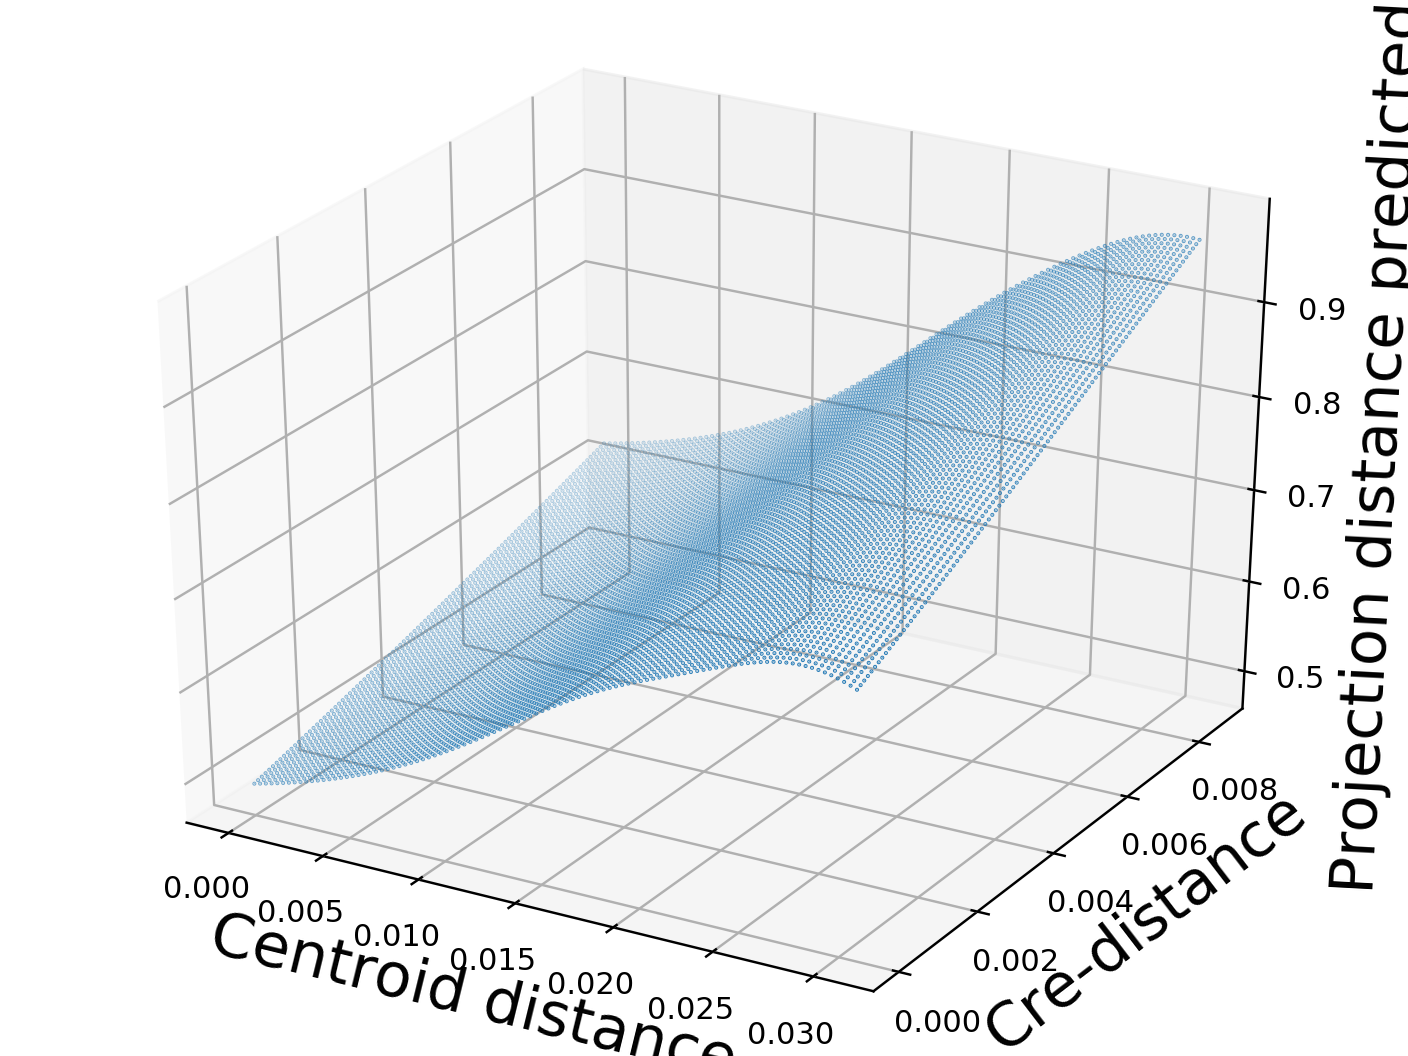

In [68]:
%matplotlib notebook
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv)
#plt.savefig('/Users/samsonkoelle/isocortexsurface')

In [69]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].smoothed_losses = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv)

In [ ]:
def get_loss_surface_cv(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances_cv, fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

In [101]:
projections = connectivity_data.structure_datas[sid].reg_proj_norm
centroids = connectivity_data.structure_datas[sid].centroids
cres = connectivity_data.creline[sid]
sids = connectivity_data.structure_datas[sid].summary_structures
fraction = frac_learn[m]
gamma = gammas_surface[m]

In [102]:
    means_cast = get_means(projections, cres, sids)


In [105]:
cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [108]:
len(np.where(~np.isnan(cre_distances_cv[1]))[0])

207

In [121]:
    proj = projections
    #def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #i = 1
        print(i)
        #meani = meani = means_cast[sids[i]][cres[i]]
        meani = means_cast[sids[i]][cres[i]]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))

        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan

        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)

    #return(credist)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [122]:
print(len(np.where(~np.isnan(credist[1,:]))[0]))

207

In [119]:
print(len(np.where(~np.isnan(credist[:,1]))[0]))

244

In [112]:
cre_distances_cv = credist

In [104]:
    
    surface = get_surface_from_distances(projections,centroids,cre_distances_cv, fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

207

207

18

244

In [83]:

print(len(np.where(~np.isnan(surface.cre_distances_cv[1]))[0]))
print(len(np.where(~np.isnan(surface.cre_distances_cv[:,1]))[0]))
sid = 315
print(len(np.where(~np.isnan(connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv[1]))[0]))
print(len(np.where(connectivity_data.leafs[sid] == connectivity_data.leafs[sid][1])[0]))
print(len(np.where(connectivity_data.summary_structures[sid] == connectivity_data.summary_structures[sid][1])[0]))

from collections import Counter
shared_ss = np.where(connectivity_data.summary_structures[sid] == connectivity_data.summary_structures[sid][1])[0]
oooooh = np.asarray(list(Counter(connectivity_data.creline[sid][shared_ss]).items()))
print(len(np.where(oooooh[:,1] == '1')[0]))

In [70]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.str2_index_matrices[sid], 
                                                                                       connectivity_data.str2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
m 0 3 0.0020073974 nan
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
m 1 2 0.0020073974 nan
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
m 2 3 0.0020073974 nan
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
m 1 21 0.0030163364 0.0019383904569020298
e [  2   4  12  26  48 111] m [  2   4  12  26  48 111]
e [  2   4  

e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 72]
m 11 4 0.005063931 0.0029387721445051996
e [38 59] m [38 59]
e [38 59] m [38 59]
e [38 59] m [38 59]
e [38 59] m [38 59]
e [38 59] m [38 59]
e [38 59] m [38 59]
e [38 59] m [38 59]
m 12 2 0.005063931 nan
e [34 69] m [34 69]
e [34 69] m [34 69]
e [34 69] m [34 69]
e [34 69] m [34 69]
e [34 69] m [34 69]
e [34 69] m [34 69]
e [34 69] m [34 69]
m 13 2 0.005063931 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 14 0 0.005063931 nan
e [ 9 21 78] m [ 9 21 78]
e [ 9 21 78] m [ 9 21 78]
e [ 9 21 78] m [ 9 21 78]
e [ 9 21 78] m [ 9 21 78]
e [ 9 21 78] m [ 9 21 78]
e [ 9 21 78] m [ 9 21 78]
e [ 9 21 78] m [ 9 21 78]
m 15 3 0.005063931 0.0035402757232182234
e [ 0  4 10 22 29 33 35 51 57 58 75] m [ 0  4 10 22 29 33 35 51 57 58 75]
e [ 0  4 10 22 29 33 35 51 57 58 75] m [ 0  4 10 22 29 33 35 51 57 58 75]
e [ 0  4 

m 2 36 0.004280918 0.00410770461420373
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1

m 8 25 0.004280918 0.003833323207946043
e [ 151  202  217  427  450  516  553  617  649  729  732  742  750  833
  852  867  878  894  926  952  972  974 1016 1022 1051 1099 1101 1103] m [ 151  202  217  427  450  516  553  617  649  729  732  742  750  833
  852  867  878  894  926  952  972  974 1016 1022 1051 1099 1101 1103]
e [ 151  202  217  427  450  516  553  617  649  729  732  742  750  833
  852  867  878  894  926  952  972  974 1016 1022 1051 1099 1101 1103] m [ 151  202  217  427  450  516  553  617  649  729  732  742  750  833
  852  867  878  894  926  952  972  974 1016 1022 1051 1099 1101 1103]
e [ 151  202  217  427  450  516  553  617  649  729  732  742  750  833
  852  867  878  894  926  952  972  974 1016 1022 1051 1099 1101 1103] m [ 151  202  217  427  450  516  553  617  649  729  732  742  750  833
  852  867  878  894  926  952  972  974 1016 1022 1051 1099 1101 1103]
e [ 151  202  217  427  450  516  553  617  649  729  732  742  750  833
  852  867  878  

e [   1   16   18   21   23   36   40   41   42   51   54   56   69   74
   75   76   87   88   91   93   97   98  101  103  108  110  111  117
  121  124  125  126  145  148  155  164  169  173  178  183  197  199
  200  201  207  208  210  214  216  221  222  227  229  231  245  246
  249  250  260  262  268  269  270  271  289  291  300  303  305  306
  311  315  316  317  321  322  324  326  328  333  335  336  343  346
  347  348  349  351  357  358  372  374  382  394  397  398  407  410
  411  412  414  419  439  444  446  449  459  462  467  473  476  487
  490  492  493  506  511  512  513  518  521  534  550  570  573  578
  582  583  584  591  592  593  597  602  605  607  610  630  632  633
  635  641  648  662  666  669  674  675  682  687  694  696  697  698
  703  709  717  722  723  727  740  748  754  757  762  765  771  778
  779  780  786  787  791  798  802  804  806  811  815  818  819  829
  830  835  836  837  844  847  849  850  863  871  883  887  889  897
  89

e [   1   16   18   21   23   36   40   41   42   51   54   56   69   74
   75   76   87   88   91   93   97   98  101  103  108  110  111  117
  121  124  125  126  145  148  155  164  169  173  178  183  197  199
  200  201  207  208  210  214  216  221  222  227  229  231  245  246
  249  250  260  262  268  269  270  271  289  291  300  303  305  306
  311  315  316  317  321  322  324  326  328  333  335  336  343  346
  347  348  349  351  357  358  372  374  382  394  397  398  407  410
  411  412  414  419  439  444  446  449  459  462  467  473  476  487
  490  492  493  506  511  512  513  518  521  534  550  570  573  578
  582  583  584  591  592  593  597  602  605  607  610  630  632  633
  635  641  648  662  666  669  674  675  682  687  694  696  697  698
  703  709  717  722  723  727  740  748  754  757  762  765  771  778
  779  780  786  787  791  798  802  804  806  811  815  818  819  829
  830  835  836  837  844  847  849  850  863  871  883  887  889  897
  89

m 16 17 0.004280918 0.005254320989563652
e [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095] m [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095]
e [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095] m [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095]
e [  13   53   83  132  171  185  189  228  298  33

e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085]
e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085]
e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085]
e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085]
m 23 21 0.004280918 0.004165823488740923
e [  29   60  154  240  803  809  947  976 1083 1105] m [  29   60  154  240  8

e [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030] m [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030]
e [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030] m [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030]
e [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030] m [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030]
e [   5  131  153  174  175  206  223  272  331  355  360  381  

e [   2   10   15   17   25   30   34   43   45   55   61   64   67   78
   90  104  129  130  133  138  141  143  161  163  170  184  191  193
  198  224  225  232  241  258  259  267  287  320  327  332  337  342
  350  366  379  380  383  389  392  393  403  424  433  438  442  443
  445  448  481  494  501  505  515  526  531  536  543  571  574  590
  594  608  609  612  615  620  627  636  646  651  663  665  670  686
  695  701  704  705  724  728  730  743  783  792  793  794  840  841
  851  870  880  881  885  886  900  907  908  927  928  939  940  942
  950  951  954  967  970  998 1007 1011 1023 1031 1038 1048 1049 1055
 1056 1059 1069 1081 1087 1088 1091 1107 1116 1123 1124 1127] m [   2   10   15   17   25   30   34   43   45   55   61   64   67   78
   90  104  129  130  133  138  141  143  161  163  170  184  191  193
  198  224  225  232  241  258  259  267  287  320  327  332  337  342
  350  366  379  380  383  389  392  393  403  424  433  438  442  443
  445  448 

e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
m 0 11 0.0044946857 0.0026882766606535313
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
m 1 2 0.0044946857 nan
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
m 2 4 0.0044946857 nan
e [ 3  7  9 19 20] m [ 3  7  9

m 2 8 0.0024444947 0.0013837389018086599
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0024444947 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.0024444947 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0024444947 nan
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
m 6 2 0.0024444947 nan
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2

e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
m 0 5 0.003704043 0.003967035970186899
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.003704043 nan
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
m 2 3 0.003704043 nan
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
m 3 3 0.003704043 nan
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 77] m [10 14 36 77]
e [

In [71]:
meanloss_nw_leaf_leaf2_2stage

array([0.03991072, 0.60140432, 0.08136897, 0.20692969, 0.20895523,
       0.1401823 , 0.15729665, 0.0529763 , 0.2574036 , 0.14085968,
       0.04951165, 0.29871598])

In [59]:
meanloss_nw_leaf_leaf2_2stage

array([0.03991072, 0.60140432, 0.08136897, 0.20692969, 0.20884855,
       0.1401823 , 0.15729665, 0.0529763 , 0.2574036 , 0.14085968,
       0.04951165, 0.29871598])

In [63]:
meanloss_nw_leaf_leaf2_2stage

array([0.03991072, 0.60140432, 0.08136897, 0.20692969, 0.20918112,
       0.1401823 , 0.15729665, 0.0529763 , 0.2574036 , 0.14085968,
       0.04951165, 0.29871598])

In [164]:
def get_loss_surface_cv_control(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances_control(projections,centroids,np.zeros(cre_distances_cv.shape), fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances_control(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)[0]#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    return(surface)

def get_embedding_cv_control(surface, dists, cre_distances_cv):
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        #p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, 0.]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)

In [166]:
for m in range(12):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_control = get_loss_surface_cv_control(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 np.ones(connectivity_data.creline[sid].shape[0]),
                                                                                                 connectivity_data.summary_structures[sid],
                                                                                                 frac_learn[m],
                                                                                                 gamma = 1000)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91

In [167]:
len(np.where(~np.isnan(connectivity_data.structure_datas[sid].loss_surface_cv_control.cre_distances_cv[:,1]))[0])

11

In [169]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses = get_embedding_cv_control(surface = connectivity_data.structure_datas[sid].loss_surface_cv_control,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_control.cre_distances_cv)

0
1
2
3
4
5
6
7
8
9
10
11


In [170]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.str2_index_matrices[sid], 
                                                                                       connectivity_data.str2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
m 0 3 0.0020073974 0.004003568170057317
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
m 1 2 0.0020073974 0.004601204764372702
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
m 2 3 0.0020073974 0.00161938686148872
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [  1  11  14  34  55  60  62  63  67  80  84  87 100 101 105 109 115 118] m [  1  11  14  34  55  60  62  63  67  80  84  87 100 101 105 109 115 118]
e [  1  11  14  34  55  60  62  63  67  80  84  87 100 101 105 109 115 118] m [  1  11  14  34  55  60  62  63  67  80  84  87 100 101 105 109 115 118]
m 0 18 0.0030163364 0.002173026434787715
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  

e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
e [ 2 25 48 50 66 71 74 81] m [ 2 25 48 50 66 71 74 81]
m 5 8 0.005063931 0.0053577703515702456
e [13 36 46] m [13 36 46]
e [13 36 46] m [13 36 46]
e [13 36 46] m [13 36 46]
e [13 36 46] m [13 36 46]
e [13 36 46] m [13 36 46]
e [13 36 46] m [13 36 46]
e [13 36 46] m [13 36 46]
m 6 3 0.005063931 0.008689332744190816
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] 

e [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  452  470  491  559  653  656  661  681  690  751  770  777  789
  821  896  906  912  949  988 1005 1019] m [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  452  470  491  559  653  656  661  681  690  751  770  777  789
  821  896  906  912  949  988 1005 1019]
e [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  452  470  491  559  653  656  661  681  690  751  770  777  789
  821  896  906  912  949  988 1005 1019] m [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  452  470  491  559  653  656  661  681  690  751  770  777  789
  821  896  906  912  949  988 1005 1019]
e [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  452  470  491  559  653  656  661  681  690  751  770  777  789
  821  896  906  912  949  988 1005 1019] m [  24   63  115  120  127  134  142  168  212  253  301  363  368  3

m 7 62 0.004280918 0.004170643289850141
e [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118] m [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118]
e [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118] m [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118]
e [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118] m [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118]
e [  52   66  118  147  158  220  266  370  418  425  465  508  541  587
  598  667  758  775  860  923  969  992 1015 1035 1118] m [  52   66  118  147  158  220  266  370  418  4

m 13 31 0.004280918 0.0040937459850559094
e [   1   16   18   21   23   36   40   41   42   51   54   56   69   74
   75   76   87   88   91   93   97   98  101  103  108  110  111  117
  121  124  125  126  145  148  155  164  169  173  178  183  197  199
  200  201  207  208  210  214  216  221  222  227  229  231  245  246
  249  250  260  262  268  269  270  271  289  291  300  303  305  306
  311  315  316  317  321  322  324  326  328  333  335  336  343  346
  347  348  349  351  357  358  372  374  382  394  397  398  407  410
  411  412  414  419  439  444  446  449  459  462  467  473  476  487
  490  492  493  506  511  512  513  518  521  534  550  570  573  578
  582  583  584  591  592  593  597  602  605  607  610  630  632  633
  635  641  648  662  666  669  674  675  682  687  694  696  697  698
  703  709  717  722  723  727  740  748  754  757  762  765  771  778
  779  780  786  787  791  798  802  804  806  811  815  818  819  829
  830  835  836  837  844  847  8

e [   1   16   18   21   23   36   40   41   42   51   54   56   69   74
   75   76   87   88   91   93   97   98  101  103  108  110  111  117
  121  124  125  126  145  148  155  164  169  173  178  183  197  199
  200  201  207  208  210  214  216  221  222  227  229  231  245  246
  249  250  260  262  268  269  270  271  289  291  300  303  305  306
  311  315  316  317  321  322  324  326  328  333  335  336  343  346
  347  348  349  351  357  358  372  374  382  394  397  398  407  410
  411  412  414  419  439  444  446  449  459  462  467  473  476  487
  490  492  493  506  511  512  513  518  521  534  550  570  573  578
  582  583  584  591  592  593  597  602  605  607  610  630  632  633
  635  641  648  662  666  669  674  675  682  687  694  696  697  698
  703  709  717  722  723  727  740  748  754  757  762  765  771  778
  779  780  786  787  791  798  802  804  806  811  815  818  819  829
  830  835  836  837  844  847  849  850  863  871  883  887  889  897
  89

m 16 17 0.004280918 0.005240514455648901
e [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095] m [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095]
e [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095] m [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095]
e [  13   53   83  132  171  185  189  228  298  33

e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085]
e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085]
e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085]
e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085]
e [   8   22   65   81  113  156  167  255  390  451  468  503  640  702
  710  715  784  916 1032 1065 1085] m [   8   

m 28 20 0.004280918 0.005280503804168584
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 29 0 0.004280918 nan
e [ 100  159  162  376  457  719  767  796  801  858  884 1112] m [ 100  159  162  376  457  719  767  796  801  858  884 1112]
e [ 100  159  162  376  457  719  767  796  801  858  884 1112] m [ 100  159  162  376  457  719  767  796  801  858  884 1112]
e [ 100  159  162  376  457  719  767  796  801  858  884 1112] m [ 100  159  162  376  457  719  767  796  801  858  884 1112]
e [ 100  159  162  376  457  719  767  796  801  858  884 1112] m [ 100  159  162  376  457  719  767  796  801  858  884 1112]
e [ 100  159  162  376  457  719  767  796  801  858  884 1112] m [ 100  159  162  376  457  719  767  796  801  858  884 1112]
e [ 100  159  162  376  457  719  767  796  801  858  884 1112] m [ 100  159  162  376  457  719  767  796  801  858  884 1112]
e [ 100  159  162  376  457  719  767  796  801  858  884 1112] m [ 100  159  162  376  457  719  

e [   2   10   15   17   25   30   34   43   45   55   61   64   67   78
   90  104  129  130  133  138  141  143  161  163  170  184  191  193
  198  224  225  232  241  258  259  267  287  320  327  332  337  342
  350  366  379  380  383  389  392  393  403  424  433  438  442  443
  445  448  481  494  501  505  515  526  531  536  543  571  574  590
  594  608  609  612  615  620  627  636  646  651  663  665  670  686
  695  701  704  705  724  728  730  743  783  792  793  794  840  841
  851  870  880  881  885  886  900  907  908  927  928  939  940  942
  950  951  954  967  970  998 1007 1011 1023 1031 1038 1048 1049 1055
 1056 1059 1069 1081 1087 1088 1091 1107 1116 1123 1124 1127] m [   2   10   15   17   25   30   34   43   45   55   61   64   67   78
   90  104  129  130  133  138  141  143  161  163  170  184  191  193
  198  224  225  232  241  258  259  267  287  320  327  332  337  342
  350  366  379  380  383  389  392  393  403  424  433  438  442  443
  445  448 

m 41 34 0.004280918 0.004843772384230331
(42, 7, 1128, 1077)
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
e [ 6  8 16 17 21 22 23 25 31 35 59] m [ 6  8 16 17 21 22 23 25 31 35 59]
m 0 11 0.0044946857 0.0026398663743508696
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
m 1 2 0.0044946857 0.004312270413954962
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 10 33 44] m [ 1 10 33 44]
e [ 1 1

e [ 3  9 10 18 20 23 30 33] m [ 3  9 10 18 20 23 30 33]
m 2 8 0.0024444947 0.0013972963122643105
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0024444947 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.0024444947 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 5 0 0.0024444947 nan
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
e [15 34] m [15 34]
m 6 2 0.0024444947 0.004053807050402879
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32]
e [ 0  1  2  4  5  8 12 21 24 26 27 28 29 32] m [ 0  1  2  4  5  8 12 21 24 

e [73 77] m [73 77]
e [73 77] m [73 77]
e [73 77] m [73 77]
m 6 2 0.0021694691 0.0014889393662014898
(7, 7, 78, 1077)
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
m 0 5 0.003704043 0.003946168168995398
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.003704043 nan
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
m 2 3 0.003704043 0.003773480210404377
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
m 3 3 0.003704043 0.00473793047395367
e [10 14 36 77] m [10 14 36 77]
e [10 14 36 

In [171]:
meanloss_nw_leaf_leaf2_2stage

array([0.03819614, 0.60140432, 0.16896439, 0.25944271, 0.38154289,
       0.27722109, 0.19623644, 0.05452515, 0.40740126, 0.2452574 ,
       0.11077338, 0.32019811])

In [172]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.str2_index_matrices[sid], 
                                                                                       connectivity_data.str2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
m 0 3 0.0020073974 0.004144847162968335
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
m 1 2 0.0020073974 0.004601204764372702
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
e [ 9 17 19] m [ 9 17 19]
m 2 3 0.0020073974 0.001554398944597219
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 2  8 11 20 21 23 26 32 34] m [ 2  8 11 20 21 23 26 32 34]
e [ 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 0 18 0.0030163364 0.0021014602420023
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119] m [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 102
 104 112 119]
e [  5  15  25  28  29  40  46  47  53  59  64  65  69  92  93  96  98 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 6 3 0.005063931 0.00914001067940342
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
e [ 3  5 16 24 26 27 41 43 52] m [ 3  5 16 24 26 27 41 43 52]
m 7 9 0.005063931 0.005465466252415201
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 8 0 0.005063931 nan
e [ 7 65] m [ 7 65]
e [ 7 65] m [ 7 65]
e [ 7 65] m [ 7 65]
e [ 7 65] m [ 7 65]
e [ 7 65] m [ 7 65]
e [ 7 65] m [ 7 65]
e [ 7 65] m [ 7 65]
m 9 2 0.005063931 0.0036924234602842172
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 10 0 0.005063931 nan
e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 72]
e [15 42 61 72] m [15 42 61 

m 2 36 0.004280918 0.003968833607002774
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076]
e [ 192  261  295  507  551  700  823  866  888  922 1036 1053 1076] m [ 192  261  295  507  551  700  823  866  888  922 1036 1053 

m 9 28 0.004280918 0.0039019159804938716
e [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057] m [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057]
e [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057] m [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057]
e [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057] m [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057]
e [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057] m [  14   20   35  248  292  294  345  428  475  498  572  644  714  800
  827  834  843  869  876  913  957  968 1057]

e [   1   16   18   21   23   36   40   41   42   51   54   56   69   74
   75   76   87   88   91   93   97   98  101  103  108  110  111  117
  121  124  125  126  145  148  155  164  169  173  178  183  197  199
  200  201  207  208  210  214  216  221  222  227  229  231  245  246
  249  250  260  262  268  269  270  271  289  291  300  303  305  306
  311  315  316  317  321  322  324  326  328  333  335  336  343  346
  347  348  349  351  357  358  372  374  382  394  397  398  407  410
  411  412  414  419  439  444  446  449  459  462  467  473  476  487
  490  492  493  506  511  512  513  518  521  534  550  570  573  578
  582  583  584  591  592  593  597  602  605  607  610  630  632  633
  635  641  648  662  666  669  674  675  682  687  694  696  697  698
  703  709  717  722  723  727  740  748  754  757  762  765  771  778
  779  780  786  787  791  798  802  804  806  811  815  818  819  829
  830  835  836  837  844  847  849  850  863  871  883  887  889  897
  89

e [   1   16   18   21   23   36   40   41   42   51   54   56   69   74
   75   76   87   88   91   93   97   98  101  103  108  110  111  117
  121  124  125  126  145  148  155  164  169  173  178  183  197  199
  200  201  207  208  210  214  216  221  222  227  229  231  245  246
  249  250  260  262  268  269  270  271  289  291  300  303  305  306
  311  315  316  317  321  322  324  326  328  333  335  336  343  346
  347  348  349  351  357  358  372  374  382  394  397  398  407  410
  411  412  414  419  439  444  446  449  459  462  467  473  476  487
  490  492  493  506  511  512  513  518  521  534  550  570  573  578
  582  583  584  591  592  593  597  602  605  607  610  630  632  633
  635  641  648  662  666  669  674  675  682  687  694  696  697  698
  703  709  717  722  723  727  740  748  754  757  762  765  771  778
  779  780  786  787  791  798  802  804  806  811  815  818  819  829
  830  835  836  837  844  847  849  850  863  871  883  887  889  897
  89

m 16 17 0.004280918 0.00519912671289086
e [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095] m [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095]
e [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095] m [  13   53   83  132  171  185  189  228  298  339  406  458  463  479
  497  510  522  537  544  577  647  684  692  707  726  745  756  764
  768  769  812  848  853  877  882  930  935  943 1002 1041 1062 1064
 1089 1095]
e [  13   53   83  132  171  185  189  228  298  339

m 24 10 0.004280918 0.005095549743929594
e [ 290  314  422  464  486  585  691  761  795 1028 1109] m [ 290  314  422  464  486  585  691  761  795 1028 1109]
e [ 290  314  422  464  486  585  691  761  795 1028 1109] m [ 290  314  422  464  486  585  691  761  795 1028 1109]
e [ 290  314  422  464  486  585  691  761  795 1028 1109] m [ 290  314  422  464  486  585  691  761  795 1028 1109]
e [ 290  314  422  464  486  585  691  761  795 1028 1109] m [ 290  314  422  464  486  585  691  761  795 1028 1109]
e [ 290  314  422  464  486  585  691  761  795 1028 1109] m [ 290  314  422  464  486  585  691  761  795 1028 1109]
e [ 290  314  422  464  486  585  691  761  795 1028 1109] m [ 290  314  422  464  486  585  691  761  795 1028 1109]
e [ 290  314  422  464  486  585  691  761  795 1028 1109] m [ 290  314  422  464  486  585  691  761  795 1028 1109]
m 25 11 0.004280918 0.00497158127325113
e [ 165  177  238  285  310  404  426  496  554  595  680  716  828  915
 1020 1066 1114] m [

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


 0.0040364523535775685
e [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030] m [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030]
e [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030] m [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030]
e [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030] m [   5  131  153  174  175  206  223  272  331  355  360  381  395  429
  566  586  629  677  693  699  734  753  774  799  856  891  982 1001
 1004 1030]
e [   5  131  153  174  175  206  223  27

e [   2   10   15   17   25   30   34   43   45   55   61   64   67   78
   90  104  129  130  133  138  141  143  161  163  170  184  191  193
  198  224  225  232  241  258  259  267  287  320  327  332  337  342
  350  366  379  380  383  389  392  393  403  424  433  438  442  443
  445  448  481  494  501  505  515  526  531  536  543  571  574  590
  594  608  609  612  615  620  627  636  646  651  663  665  670  686
  695  701  704  705  724  728  730  743  783  792  793  794  840  841
  851  870  880  881  885  886  900  907  908  927  928  939  940  942
  950  951  954  967  970  998 1007 1011 1023 1031 1038 1048 1049 1055
 1056 1059 1069 1081 1087 1088 1091 1107 1116 1123 1124 1127] m [   2   10   15   17   25   30   34   43   45   55   61   64   67   78
   90  104  129  130  133  138  141  143  161  163  170  184  191  193
  198  224  225  232  241  258  259  267  287  320  327  332  337  342
  350  366  379  380  383  389  392  393  403  424  433  438  442  443
  445  448 

m 40 12 0.004280918 0.005291416226245632
e [   4  112  122  135  150  152  213  313  325  340  478  500  502  528
  535  579  589  601  603  614  616  650  678  712  831  862  938  941
  959 1012 1039 1075 1120 1122] m [   4  112  122  135  150  152  213  313  325  340  478  500  502  528
  535  579  589  601  603  614  616  650  678  712  831  862  938  941
  959 1012 1039 1075 1120 1122]
e [   4  112  122  135  150  152  213  313  325  340  478  500  502  528
  535  579  589  601  603  614  616  650  678  712  831  862  938  941
  959 1012 1039 1075 1120 1122] m [   4  112  122  135  150  152  213  313  325  340  478  500  502  528
  535  579  589  601  603  614  616  650  678  712  831  862  938  941
  959 1012 1039 1075 1120 1122]
e [   4  112  122  135  150  152  213  313  325  340  478  500  502  528
  535  579  589  601  603  614  616  650  678  712  831  862  938  941
  959 1012 1039 1075 1120 1122] m [   4  112  122  135  150  152  213  313  325  340  478  500  502  528
  535 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [10 18] m [10 18]
m 0 2 0.0040149265 0.004569162753691491
e [12 14 20 35 41] m [12 14 20 35 41]
e [12 14 20 35 41] m [12 14 20 35 41]
e [12 14 20 35 41] m [12 14 20 35 41]
e [12 14 20 35 41] m [12 14 20 35 41]
e [12 14 20 35 41] m [12 14 20 35 41]
e [12 14 20 35 41] m [12 14 20 35 41]
e [12 14 20 35 41] m [12 14 20 35 41]
m 1 5 0.0040149265 0.003109267527972806
e [28 31] m [28 31]
e [28 31] m [28 31]
e [28 31] m [28 31]
e [28 31] m [28 31]
e [28 31] m [28 31]
e [28 31] m [28 31]
e [28 31] m [28 31]
m 2 2 0.0040149265 0.0033621550209974845
e [15 26] m [15 26]
e [15 26] m [15 26]
e [15 26] m [15 26]
e [15 26] m [15 26]
e [15 26] m [15 26]
e [15 26] m [15 26]
e [15 26] m [15 26]
m 3 2 0.0040149265 0.003175726843515589
e [ 6 34 43] m [ 6 34 43]
e [ 6 34 43] m [ 6 34 43]
e [ 6 34 43] m [ 6 34 43]
e [ 6 34 43] m [ 6 34 43]
e [ 6 34 43] m [ 6 34 43]
e [ 6 34 43] m [ 6 34 43]
e [ 6 34 43] m [ 6 34 43]
m 4 3 0.0040149265 0.004058392933169954
e [19 21 23 37 44] m [19 21 23 37 44]
e [19 21 23 3

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 0 6 0.0047248537 0.0065902358443645755
e [ 3  9 10 14 16 19 21 23] m [ 3  9 10 14 16 19 21 23]
e [ 3  9 10 14 16 19 21 23] m [ 3  9 10 14 16 19 21 23]
e [ 3  9 10 14 16 19 21 23] m [ 3  9 10 14 16 19 21 23]
e [ 3  9 10 14 16 19 21 23] m [ 3  9 10 14 16 19 21 23]
e [ 3  9 10 14 16 19 21 23] m [ 3  9 10 14 16 19 21 23]
e [ 3  9 10 14 16 19 21 23] m [ 3  9 10 14 16 19 21 23]
e [ 3  9 10 14 16 19 21 23] m [ 3  9 10 14 16 19 21 23]
m 1 8 0.0047248537 0.0036334990582415263
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
e [ 1  2  7 22 24 27] m [ 1  2  7 22 24 27]
m 2 6 0.0047248537 0.004350818576502425
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0047248537 nan
e [13 20 25 28] m [13 20 25 28]
e [13 20 25 28] m [13 20 25 28]
e [13 20 25 28] m [13

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


m 5 43 0.0021694691 0.001844589046482787
e [73 77] m [73 77]
e [73 77] m [73 77]
e [73 77] m [73 77]
e [73 77] m [73 77]
e [73 77] m [73 77]
e [73 77] m [73 77]
e [73 77] m [73 77]
m 6 2 0.0021694691 0.0014889393662014898
(7, 7, 78, 1077)
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
e [13 43 46 48 57] m [13 43 46 48 57]
m 0 5 0.003704043 0.003820099615255865
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 1 0 0.003704043 nan
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
m 2 3 0.003704043 0.003994902377383073
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] m [30 38 68]
e [30 38 68] 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:143: RuntimeWarning: Mean of empty slice
  print('m', m, len(np.where(model_index_matrix[m] == 1)[0]), np.nanmean(projections), np.nanmean(predictions[m]))


e [73 74] m [73 74]
e [73 74] m [73 74]
e [73 74] m [73 74]
m 8 2 0.003704043 0.002725882180545504
e [ 9 45 51 61] m [ 9 45 51 61]
e [ 9 45 51 61] m [ 9 45 51 61]
e [ 9 45 51 61] m [ 9 45 51 61]
e [ 9 45 51 61] m [ 9 45 51 61]
e [ 9 45 51 61] m [ 9 45 51 61]
e [ 9 45 51 61] m [ 9 45 51 61]
e [ 9 45 51 61] m [ 9 45 51 61]
m 9 4 0.003704043 0.004949687069002146
e [ 4 19 33 60 79] m [ 4 19 33 60 79]
e [ 4 19 33 60 79] m [ 4 19 33 60 79]
e [ 4 19 33 60 79] m [ 4 19 33 60 79]
e [ 4 19 33 60 79] m [ 4 19 33 60 79]
e [ 4 19 33 60 79] m [ 4 19 33 60 79]
e [ 4 19 33 60 79] m [ 4 19 33 60 79]
e [ 4 19 33 60 79] m [ 4 19 33 60 79]
m 10 5 0.003704043 0.0035458684364085757
e [23 24 52 64 75] m [23 24 52 64 75]
e [23 24 52 64 75] m [23 24 52 64 75]
e [23 24 52 64 75] m [23 24 52 64 75]
e [23 24 52 64 75] m [23 24 52 64 75]
e [23 24 52 64 75] m [23 24 52 64 75]
e [23 24 52 64 75] m [23 24 52 64 75]
e [23 24 52 64 75] m [23 24 52 64 75]
m 11 5 0.003704043 0.002584759415533047
e [ 1  2  6 37 63 65 69 7

In [173]:
meanloss_nw_leaf_leaf2_2stage

array([0.04845521, 0.60140432, 0.14698701, 0.23312203, 0.29754594,
       0.20540077, 0.18755991, 0.05589402, 0.33901381, 0.24460895,
       0.08278635, 0.29520981])

In [113]:
for m in range(4,5):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].smoothed_losses = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv)

In [114]:

    #def get_embedding_cv(surface, dists, cre_distances_cv):
    surface = connectivity_data.structure_datas[sid].loss_surface_cv
    dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv
    
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    #return(losses)


In [115]:
nlp

79293

In [ ]:
def get_loss_surface(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances = get_cre_distances(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma)
    return(surface)

In [ ]:

for m in range(4,5):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                 connectivity_data.creline[sid],
                                                                                 connectivity_data.structure_datas[sid].summary_structures,
                                                                                 
                                                                                 #connectivity_data.structure_datas[sid].summary_structures,
                                                                                 #connectivity_data.s[sid],
                                                                                 frac_learn[m],
                                                                                 gamma = gammas_surface[m])

In [123]:
#def get_surface_from_distances2(projections,centroids,cre_distances, fraction, gamma = 100000):
def get_surface_from_distances2(projections,distances, fraction, gamma = 100000):
      
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(distances[0]))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,distances.shape[0]))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        for d in range(distances.shape[0]):
            coordinates[i,d] = distances[d][pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

In [ ]:
for sid in major_structure_ids:
    get_loss_surface_cv2(projections = connectivity_data.structure_datas[sid].reg_proj_norm,
                        centroids = connectivity_data.structure_datas[sid].centroids,
                        ids = creleafs_merged[sid],
                        fraction = .1,
                        gamma = 100000)

In [145]:

    #make distances nan in regions where they should not be computed
    def get_censor_matrix(ids1, ids2):

        nd = len(ids1)
        output = np.zeros((nd,nd))
        for d in range(nd):
            shared_ss = np.where(ids1 == ids1[i])[0]
            oooooh = np.asarray(list(Counter(ids2[shared_ss]).items()))
            kept = np.where(np.asarray(oooooh[:,1], dtype = int) > 1)[0]
            output[d][shared_ss[np.where(np.isin(ids2[shared_ss], oooooh[:,0][kept]))]] = np.nan
        output[np.where(~np.isnan(output))] = 1
        return(output)    

    def get_creleaf_combos(self):

        connectivity_data = self
        leafs = self.leafs
        creline = self.creline
        creleafs = {}
        creleafs_merged = {}

        major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
        for sid in major_structure_ids:
            creleafs[sid] = np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype=str).transpose()
            creleafs_merged[sid] = [creleafs[sid][:, 0][i] + creleafs[sid][:, 1][i] for i in range(creleafs[sid].shape[0])]
            creleafs_merged[sid] = np.asarray(creleafs_merged[sid])
        self.creleaf_combos = creleafs_merged

        
    def get_loss_surface_cv2(y, x, groups, ids1, ids2, fraction, gamma = 100000):
        #means_cast = get_means(projections, cres, sids)
        #cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
        
        ng = len(np.unique(groups))
        for g in range(ng):
            gids = np.where(groups == g)[0]
            distances[g] = pairwise_distances(x[:,g])**2
        

        #combined_ids = get_combined_ids(ids) # connectivity_data.creleaf_combos[sid]
        censor_matrix = get_censor_matrix(ids1, ids2)
        censored_distances = distances * censor_matrix
        surface = get_surface_from_distances2(y,np.asarray([censored_distances]), fraction, gamma)
        #surface.cre_distances_cv = cre_distances_cv
        return(surface, censored_distances)

In [147]:
a,b = get_loss_surface_cv2(projections, 
                     centroids, 
                     connectivity_data.summary_structures[sid],
                     connectivity_data.creline[sid], fraction, gamma = 100000)

In [154]:
len(np.where(~np.isnan(b[:,1]))[0])

1128

In [155]:
b[:,1]

array([1019.29319181,    0.        , 2388.34474626, ...,  108.1800643 ,
        585.65680656, 5381.20744981])

In [152]:
np.isnan(b[1])

#len(np.where(oooooh[:,1] == '1')[0])        

array([False, False,  True, ..., False, False,  True])

In [125]:
shared_ss = np.where(connectivity_data.summary_structures[sid] == connectivity_data.summary_structures[sid][1])[0]
oooooh = np.asarray(list(Counter(connectivity_data.creline[sid][shared_ss]).items()))
len(np.where(oooooh[:,1] == '1')[0])        

16

In [ ]:
#distances should be censored to experiments sharing the same code

In [ ]:

for m in range(4,5):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                 connectivity_data.creline[sid],
                                                                                 connectivity_data.structure_datas[sid].summary_structures,
                                                                                 
                                                                                 #connectivity_data.structure_datas[sid].summary_structures,
                                                                                 #connectivity_data.s[sid],
                                                                                 frac_learn[m],
                                                                                 gamma = gammas_surface[m])